## Predicting the Students Dropout Rates

## Introduction

Students drop-out rates is one of the challenges faced by many schools globally.Addressing this problem requires a better planning for interventions and a more thorough understanding of the fundamental issues that cause theproblem. Machine learning provides a convenient way to accurately identify and prioritize students and schools at risk and thus deliver good guarantees for the solutions.

Presented below is the final experiment to demostrate 3 algorithms which have archived high perfomance metrics.
- Algorithms:
  1. Multilayer Perceptron
  2. Logistic Regression
  3. Random Forest
  
- Perfomance metrics:
   1. G-mean
   2. Adjusted Geometric Mean
   3. F-Measure
   
- Procedure:
   1. Stratified 5-fold cross-validation

#### Technique: 
- Random over-sampling, random under-sampling, no sampling SMOTE, SMOTE+ENN, Smote + Tomek links.

#### Metrics:  
 - G-mean (geometric mean), Adjusted Geometric Mean and F-measure.

#### Models: 
- MLP (Neural networks model) , LR (Linear model) and RF (Ensemble model)

#### Procedure: 
- Stratified 5-fold cross-validation

In [1]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import  RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler

In [2]:
class Technique:
    
    def __init__(self,data):
        self.y = data.loc[:,'Dropout']
        self.X = data.drop('Dropout',1)
        
    def random_over_sampling(self):
        return RandomOverSampler(random_state=0).fit_sample(self.X, self.y)
    
    def random_under_sampling(self):
        return RandomUnderSampler(random_state=0).fit_sample(self.X, self.y)
    
    def smote(self):
        return SMOTE(kind = "regular").fit_sample(self.X, self.y)
    
    def smote_tomek_links(self):
        return SMOTETomek(random_state=0).fit_sample(self.X, self.y)
        
    def smote_enn(self):
        return SMOTEENN(random_state=0).fit_sample(self.X, self.y)
      

In [3]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [4]:
 class Metrics:
        
        def __init__(self,ytrue,ypred):
            self.conf_matrix   = confusion_matrix(ytrue, ypred)
            self.true_positive = self.conf_matrix[1,1]
            self.true_negative = self.conf_matrix[0,0]
            self.false_positive= self.conf_matrix[0,1]
            self.false_negative= self.conf_matrix[1,0]
            
            self.tpr = self.true_positive / float(self.false_negative + self.true_positive)
            self.tnr = self.true_negative / float(self.true_negative + self.true_positive) 
            self.fpr = self.false_positive / float(self.true_positive + self.false_positive)
            self.fnr = self.false_negative / float(self.true_positive + self.false_negative)
            self.ppv = self.true_positive / float(self.true_positive + self.false_positive)
            
        def gm(self):
            return np.sqrt(self.tpr*self.tnr)

        def agm(self):    
            return (self.gm() + self.tnr)*(self.false_positive + self.true_negative)/\
        (1 + self.false_positive  + self.true_negative) if self.tpr > 0 else 0

        def f_score(self):
            return 2*self.ppv*self.tnr/(self.ppv + self.tnr)
            

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [6]:
class Models:
    
    def __init__(self):
        self.MLP = MLPClassifier()
        self.LR  = LogisticRegression()
        self.RF  = RandomForestClassifier()

    def multlayer_paceptron(self):
        return self.MLP
    
    def logistic_regression(self):
        return self.LR
    
    def random_forest(self):
        return self.RF
    

In [7]:
from sklearn import model_selection, cross_validation
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
def test_result(X_val,y_val, model):
    ypred_val = model.predict(X_val)
    metrics = Metrics(ypred_val, y_val)
    gm, agm,fscore= metrics.gm(),metrics.agm(),metrics.f_score()
    return  gm, agm,fscore

In [9]:
def cross_validate(model, x, y, xval,yval, folds=5, repeats=5):
    
    ypred     = np.zeros((len(y),repeats))
    ypred_val = np.zeros((len(yval),repeats))
    gm        = np.zeros(repeats)
    agm       = np.zeros(repeats)
    f_score   = np.zeros(repeats)
    gm_val    = np.zeros(repeats)
    agm_val   = np.zeros(repeats)
    f_score_val = np.zeros(repeats)
    
    for r in range(repeats):
        i=0
        x,y = shuffle(x,y,random_state=r)
        kf = model_selection.StratifiedKFold(n_splits=folds,  shuffle=True, random_state=i+1000)
        for train_ind,test_ind in kf.split(x,y):
            xtrain,ytrain = x[train_ind,:],y[train_ind]
            xtest,ytest = x[test_ind,:],y[test_ind]
            model.fit(xtrain, ytrain)
            ypred[test_ind,r] = model.predict(xtest)
            i+=1
            metrics = Metrics(ypred[:,r],y)
            gm[r], agm[r],f_score[r]= metrics.gm(),metrics.agm(),metrics.f_score()
            gm_val[r], agm_val[r], f_score_val[r]= test_result(xval,yval, model)
            
            
    return  np.mean(gm),np.mean(agm),np.mean(f_score),np.mean(gm_val),\
np.mean(agm_val),np.mean(f_score_val)

## DATA VISUALIZATION

In [10]:
import pandas as pd

In [11]:
def load_cleandata(file_name):
    '''
    Function to load saved clean data (train, test and valiadtion set) 
    file_name = path of the data
    '''
    df = pd.read_csv(file_name)
    df.drop('Unnamed: 0', axis=1, inplace=True)

    return df

In [12]:
train_data = load_cleandata("train.csv")

In [13]:
import matplotlib.pyplot as plt

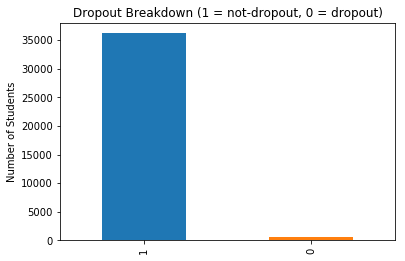

In [14]:
ax = train_data.Dropout.value_counts().plot(kind='bar')
ax.set_title("Dropout Breakdown (1 = not-dropout, 0 = dropout)")
ax.set_ylabel("Number of Students")
plt.savefig('images/original_data.pdf');
plt.show()

### APPLYING IMBALANCE TECHNIQUES

In [15]:
imbalance_technique = Technique(train_data)

In [16]:
def graph(name,technique,unique,counts):
    bar_width = 0.2
    postion = np.arange(len(unique))
    plt.bar(postion, counts, bar_width, align='center')
    plt.xticks(postion, unique, rotation=0)
    plt.title(technique+" Dropout Breakdown (1 = not-dropout, 0 = dropout)")
    plt.ylabel("Number of Students")
    plt.savefig('images/'+name+'.pdf');
    return plt.show()

#### 1: RANDOM OVER SAMPLING

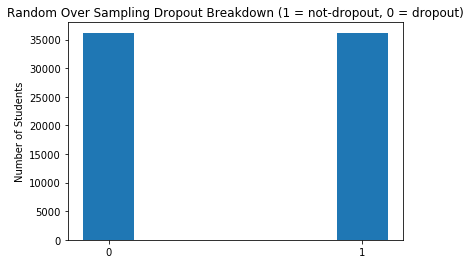

In [17]:
_, y_over = imbalance_technique.random_over_sampling()
unique, counts = np.unique(y_over, return_counts=True)
graph('random_over_sampling',"Random Over Sampling",unique,counts)

#### 2: RANDOM UNDER SAMPLING

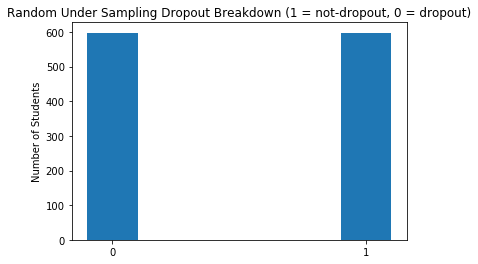

In [18]:
_, y_under = imbalance_technique.random_under_sampling()
unique, counts = np.unique(y_under, return_counts=True)
graph('random_under_sampling',"Random Under Sampling",unique,counts)

#### 3: SMOTE

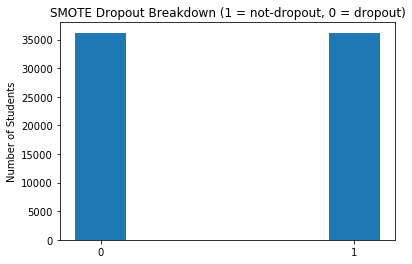

In [19]:
_, y_smote = imbalance_technique.smote()
unique, counts = np.unique(y_smote, return_counts=True)
graph('somte',"SMOTE",unique,counts)

#### 4: SMOTE TOMEK LINKS

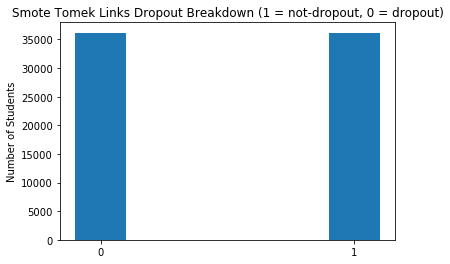

In [20]:
_, y_smote_tomek = imbalance_technique.smote_tomek_links()
unique, counts = np.unique(y_smote_tomek, return_counts=True)
graph('smote_tomek_links',"Smote Tomek Links",unique,counts)

#### 4: SMOTE ENN

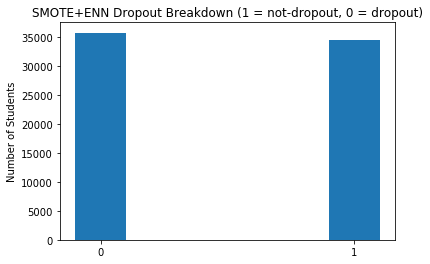

In [21]:
_, y_smote_enn = imbalance_technique.smote_enn()
unique, counts = np.unique(y_smote_enn, return_counts=True)
graph('smote_enn',"SMOTE+ENN",unique,counts)

## Evaluation Of Imbalance Techniques For Each Model

In [22]:
def experiment(X,y,X_val,y_val):
    
    gm_train = []
    agm_train = []
    f_score_train = []
    gm_val = []
    agm_val = []
    f_score_val = []
    
    names  = ['MLP','LR','RF']
    model  = Models()
    models = [model.multlayer_paceptron(),model.logistic_regression(),model.random_forest()]
    
    for (i,clf) in enumerate(models):
        print('Cross Validating - ', str(names[i]))
        gm_t, agm_t,f_t, gm_v, agm_v, f_v =  cross_validate(clf, np.array(X), y, X_val,y_val,\
                                                                           folds=5, repeats=5) 
        gm_train.append(gm_t)
        agm_train.append(agm_t)
        f_score_train.append(f_t)
        gm_val.append(gm_v)
        agm_val.append(agm_v)
        f_score_val.append(f_v)
        
    results = {'name':names,
               'train_gm':gm_train,
               'train_agm':agm_train,
               'train_fscore':f_score_train,
               'val_gm':gm_val,
               'val_agm':agm_val,
               'val_fscore':f_score_val}
    return results     

In [23]:
def plot_valiadation(plot_name, plot_title, results):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    position = np.arange(len(results['name']))
    bar_width = 0.15

    plt.bar(position - bar_width, results['val_gm'], bar_width,label='$G_m$')
    plt.bar(position, results['val_fscore'], bar_width, label='$F_m$')
    plt.bar(position + bar_width, results['val_agm'], bar_width,label='$AG_m$')
    plt.ylabel('Validation Scores')
    plt.title(plot_title)
    plt.xticks(position, results['name'],rotation=90)
    ax.legend(bbox_to_anchor=(1, 0.25), loc='best', ncol=1)
    plt.savefig('images/'+plot_name+'.pdf');
    plt.show()

In [24]:
def plot_training(plot_name, plot_title, results):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    position = np.arange(len(results['name']))
    bar_width = 0.15

    plt.bar(position - bar_width, results['train_gm'], bar_width,label='$G_m$')
    plt.bar(position, results['train_fscore'], bar_width, label='$F_m$')
    plt.bar(position + bar_width, results['train_agm'], bar_width,label='$AG_m$')
    plt.ylabel('Training Scores')
    plt.title(plot_title)
    plt.xticks(position, results['name'],rotation=90)
    ax.legend(bbox_to_anchor=(1, 0.25), loc='best', ncol=1)
    plt.savefig('images/'+plot_name+'.pdf');
    plt.show()

In [25]:
train_data = load_cleandata("train.csv")
val_data = load_cleandata("validate.csv")

y_train = train_data.loc[:,'Dropout']
X_train = train_data.drop('Dropout',1)

y_validate = val_data.loc[:,'Dropout']
X_validate = val_data.drop('Dropout',1)

#### Step 0: NO SAMPLING

In [26]:
results = experiment(X_train,y_train,X_validate,y_validate)

Cross Validating -  MLP
Cross Validating -  LR
Cross Validating -  RF


plot_training(plot_name="Training_results_no_sampling", \
              plot_title="Experiment 1: Training Results by Models (No Sampling)", results=results)

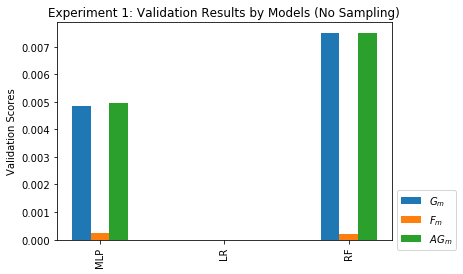

In [27]:
plot_valiadation(plot_name="Validation_results_no_sampling", \
                 plot_title="Experiment 1: Validation Results by Models (No Sampling)", results=results)

#### Step 1: RANDOM OVER SAMPLING

In [28]:
imbalance_technique_train = Technique(train_data)
imbalance_technique_validate = Technique(val_data)

In [29]:
x_over_train, y_over_train = imbalance_technique_train.random_over_sampling()
x_over_validate, y_over_validate = imbalance_technique_validate.random_over_sampling()

In [30]:
results = experiment(x_over_train,y_over_train,x_over_validate,y_over_validate)

Cross Validating -  MLP
Cross Validating -  LR
Cross Validating -  RF


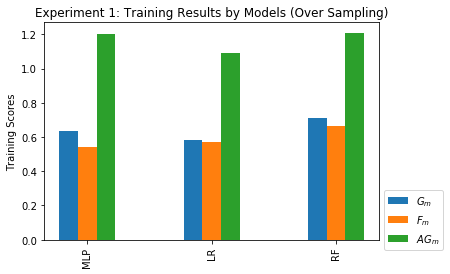

In [31]:
plot_training(plot_name="Training_results_over_sampling", \
              plot_title="Experiment 1: Training Results by Models (Over Sampling)", results=results)

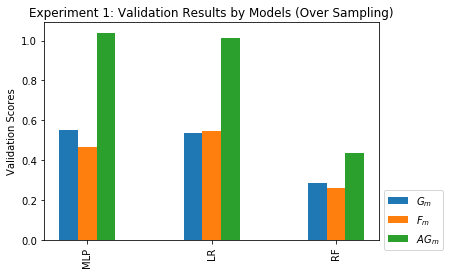

In [32]:
plot_valiadation(plot_name="Validation_results_Over_sampling", \
                 plot_title="Experiment 1: Validation Results by Models (Over Sampling)", results=results)

#### Step 2: RANDOM UNDER SAMPLING

In [33]:
x_under_train, y_under_train = imbalance_technique_train.random_under_sampling()
x_under_validate, y_under_validate = imbalance_technique_validate.random_under_sampling()

In [34]:
results = experiment(x_under_train,y_under_train,x_under_validate,y_under_validate)

Cross Validating -  MLP
Cross Validating -  LR
Cross Validating -  RF


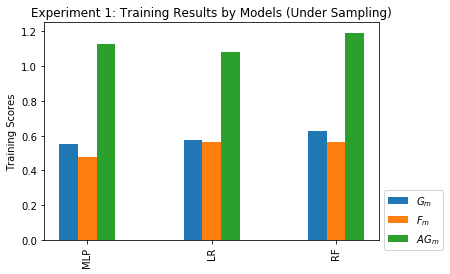

In [35]:
plot_training(plot_name="Training_results_Under_sampling", \
              plot_title="Experiment 1: Training Results by Models (Under Sampling)", results=results)

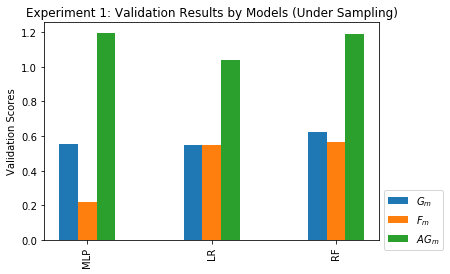

In [36]:
plot_valiadation(plot_name="Validation_results_Over_sampling", \
                 plot_title="Experiment 1: Validation Results by Models (Under Sampling)", results=results)

#### Step 3: SMOTE

In [37]:
x_smote_train, y_smote_train = imbalance_technique_train.smote()
x_smote_validate, y_smote_validate = imbalance_technique_validate.smote()

In [38]:
results = experiment(x_smote_train,y_smote_train,x_smote_validate,y_smote_validate)

Cross Validating -  MLP
Cross Validating -  LR
Cross Validating -  RF


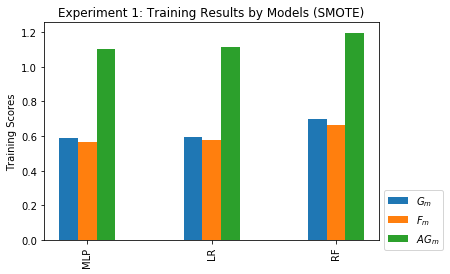

In [39]:
plot_training(plot_name="Training_results_SMOTE", \
              plot_title="Experiment 1: Training Results by Models (SMOTE)", results=results)

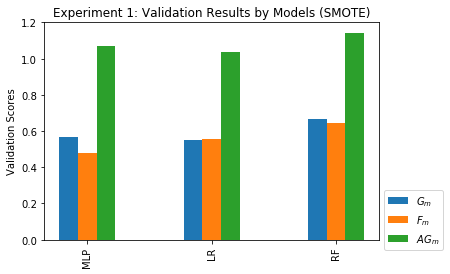

In [40]:
plot_valiadation(plot_name="Validation_results_SMOTE", \
                 plot_title="Experiment 1: Validation Results by Models (SMOTE)", results=results)

#### Step 3: SMOTE TOMEK LINKS

In [41]:
x_smote_tomek_links_train, y_smote_tomek_links_train = imbalance_technique_train.smote_tomek_links()
x_smote_tomek_links_validate, y_smote_tomek_links_validate = imbalance_technique_validate.smote_tomek_links()

In [42]:
results = experiment(x_smote_tomek_links_train,y_smote_tomek_links_train,x_smote_tomek_links_validate,\
                     y_smote_tomek_links_validate)

Cross Validating -  MLP
Cross Validating -  LR
Cross Validating -  RF


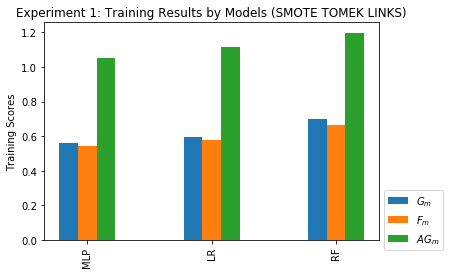

In [43]:
plot_training(plot_name="Training_results_SMOTE_TOMEK_LINKS", \
              plot_title="Experiment 1: Training Results by Models (SMOTE TOMEK LINKS)", results=results)

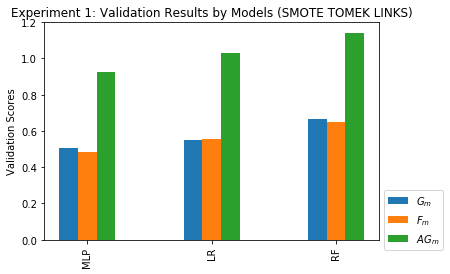

In [44]:
plot_valiadation(plot_name="Validation_results_SMOTE_TOMEK_LINKS", \
                 plot_title="Experiment 1: Validation Results by Models (SMOTE TOMEK LINKS)", results=results)

#### Step 4: SMOTE + ENN

In [45]:
x_smote_enn_train, y_smote_enn_train = imbalance_technique_train.smote_enn()
x_smote_enn_validate, y_smote_enn_validate = imbalance_technique_validate.smote_enn()

In [46]:
results = experiment(x_smote_enn_train,y_smote_enn_train,x_smote_enn_validate,y_smote_enn_validate)

Cross Validating -  MLP
Cross Validating -  LR
Cross Validating -  RF


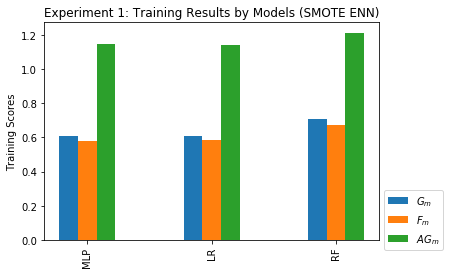

In [47]:
plot_training(plot_name="Training_results_SMOTE_ENN", \
              plot_title="Experiment 1: Training Results by Models (SMOTE ENN)", results=results)

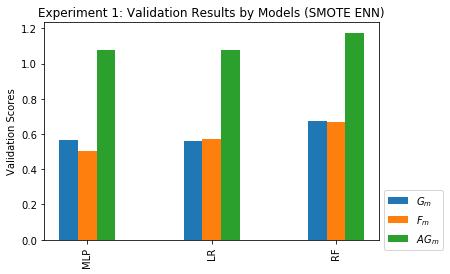

In [48]:
plot_valiadation(plot_name="Validation_results_SMOTE_ENN", \
                 plot_title="Experiment 1: Validation Results by Models (SMOTE ENN)", results=results)